# Seminar 5 - DCT and MDCT

4 subband FFT filter bank should be comared with FB from Seminar 3.

In [4]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
import copy
import pickle
plt.rcParams['figure.figsize'] = [8,6]

Load audio file

In [2]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


In [18]:
nSubbands = 8

### Task 1: Setting 1

DCT4

DCT via DCT Matrix

In [4]:
def generate_dct_matrix(N):
    n = np.arange(0, N)
    k = np.arange(0, N)
    T = np.zeros((N, N))
    
    for nn in n:
        for kk in k:
            T[nn][kk] = np.sqrt(2.0/N) * np.cos( (np.pi/N) * (nn+0.5) * (kk+0.5))
            
    return T

In [5]:
T = generate_dct_matrix(nSubbands)

# Analysis filterbank (= flipped columns)
fb_a = []
[fb_a.append(np.flipud(T[:, cIdx])) for cIdx in np.arange(nSubbands)]

# Synthesis filterbank (= rows)
fb_s = []
[fb_s.append(T[rIdx, :]) for rIdx in np.arange(nSubbands)]



[None, None, None, None, None, None, None, None]

Plot Frequency Responses

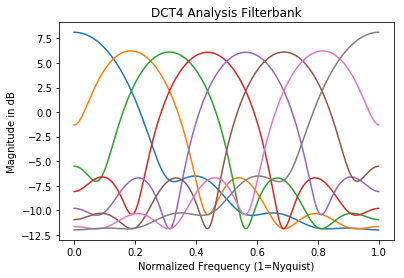

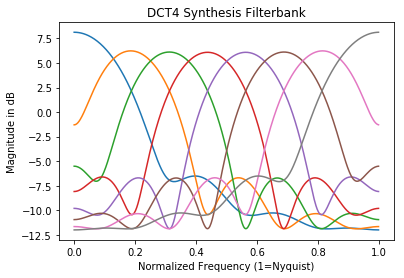

In [6]:
for h in fb_a:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H)))
    plt.title('DCT4 Analysis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')
 
plt.show()

for h in fb_s:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H)))
    plt.title('DCT4 Synthesis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')
    
plt.show()

Use filterbank on audio signal and downsample

In [7]:
decomposed = [np.convolve(h,audio,mode='full') for h in fb_a]
downsampledBands = [s[::nSubbands] for s in decomposed]

Reconstruction:
* upsampling and filtering
* add subbands together

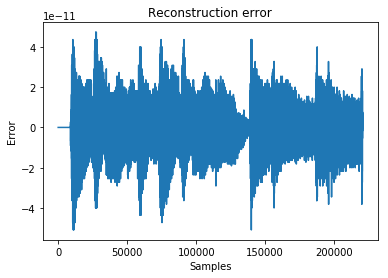

In [8]:
zeroBands = [np.zeros_like(band) for band in decomposed]
usBands = []
for zBand, dsBand in zip(zeroBands, downsampledBands):
    zBand[::nSubbands] = dsBand
    usBands.append(zBand)

filterdUs = [np.convolve(h,band,mode='full') for h,band in zip(fb_s, usBands)]
recon = np.zeros_like(filterdUs[0])
for band in filterdUs:
    recon += band

error = audio - recon[7:-7]
plt.plot(error)
plt.title('Reconstruction error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.show()

In [9]:
print('Play reconstructed audio:')
recon = 32768 * recon / max(abs(recon))
sound.sound(recon,fs)

print('Play original audio:')
audio = 32768 * audio / max(abs(audio))
sound.sound(audio, fs)

Play reconstructed audio:
* done
Play original audio:
* done


In [10]:
wav.write('Setting1_recon.wav', fs, recon)
pickle.dump(downsampledBands, open( "setting1.bin", "wb" ))

### Task 1: Setting 2

DCT4: some subbands set to zero

In [11]:
nSubbandsRemaining = 3
fb_a0 = copy.deepcopy(fb_a)

for i in np.arange(nSubbandsRemaining, nSubbands):
    fb_a0[i] = np.zeros_like(fb_a[i])

Use filterbank on audio signal and downsample

In [12]:
decomposed = [np.convolve(h,audio,mode='full') for h in fb_a0]
downsampledBands = [s[::nSubbands] for s in decomposed]

Reconstruction:
* upsampling and filtering
* add subbands together

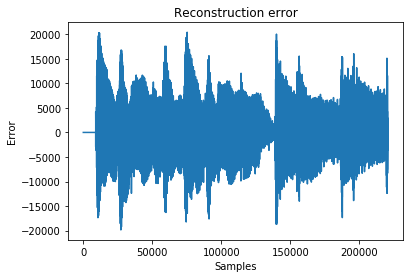

In [13]:
zeroBands = [np.zeros_like(band) for band in decomposed]
usBands = []
for zBand, dsBand in zip(zeroBands, downsampledBands):
    zBand[::nSubbands] = dsBand
    usBands.append(zBand)

filterdUs = [np.convolve(h,band,mode='full') for h,band in zip(fb_s, usBands)]
recon = np.zeros_like(filterdUs[0])
for band in filterdUs:
    recon += band

error = audio - recon[7:-7]
plt.plot(error)
plt.title('Reconstruction error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.show()

In [14]:
print('Play reconstructed audio:')
recon = 32768 * recon / max(abs(recon))
sound.sound(recon,fs)

print('Play original audio:')
audio = 32768 * audio / max(abs(audio))
sound.sound(audio, fs)

Play reconstructed audio:
* done
Play original audio:
* done


In [16]:
wav.write('Setting2_recon.wav', fs, recon)
savebands = downsampledBands[:nSubbandsRemaining]
pickle.dump(savebands, open( "setting2.bin", "wb" ))

### Task 1: Setting 1

MDCT

In [11]:
def Famatrix(h):
    """produces a diamond shaped folding matrix F from the coefficients f
    (h is a row matrix)
    """
    
    N = int(len(h)/2);
    N_2 = int(N/2)
 
    #fliplr:
    h=h[::-1]  
    Fa=np.zeros((N,N,1))
    Fa[0:N_2,0:N_2,0]=-np.fliplr(np.diag(h[0:N_2]))
    Fa[N_2:N,0:N_2,0]=-np.diag(h[N_2:N])
    Fa[0:N_2,N_2:N,0]=-np.diag(h[N:(N+N_2)]) 
    Fa[N_2:N,N_2:N,0]=np.fliplr(np.diag(h[(N+N_2):2*N]))
    
    return Fa

def sinWindow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        s = np.sin(np.pi/N*(n+0.5))
    else:
        s = np.sin(np.pi/(N+1)*(n+1))
    return s

In [25]:
#Sine Window
h = sinWindow(2*nSubbands)

#Folding Matrix:
Fa=Famatrix(h)

#Delay Matrix D(z):
N_2 = int(nSubbands/2)
Dp = np.zeros((nSubbands,nSubbands,2))
Dp[:,:,0] = np.diag(np.hstack((np.zeros(N_2), np.ones(N_2)))) #z^0
Dp[:,:,1] = np.diag(np.hstack((np.ones(N_2), np.zeros(N_2)))) #z^-1

print(Dp)

[[[ 0.  1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  1.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]]]
